In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from MAppServer.settings import DOWNLOAD_FOLDER_ABSOLUTE_PATH
from data_analysis.subjects_to_keep import subjects_to_keep


In [3]:
users = subjects_to_keep

In [9]:
df_step_content = []
n_user_skipped = 0

for user in tqdm(users):

    if "smallobj" in user or "michele" in user or "student" in user:
        print(f"Skipping user `{user}` (test user)")
        continue

    file = ""
    for file_ in glob.glob(f"{DOWNLOAD_FOLDER_ABSOLUTE_PATH}/{user}_reward*.csv"):
        file = file_
        break
    df_rwd = pd.read_csv(file, index_col=0)
    df_rwd["dt"] = pd.to_datetime(df_rwd["date"], utc=False)
    df_rwd["dt"] = df_rwd["dt"].dt.tz_localize('Europe/London')

    for file_ in glob.glob(f"{DOWNLOAD_FOLDER_ABSOLUTE_PATH}/{user}_activity*.csv"):
        file = file_
        break
    df_act = pd.read_csv(file, index_col=0)
    if len(df_act) < 100:
        print(f"Skipping user `{user}`, not enough activity records (n={len(df_act)})")
        continue

    df_act.dt = pd.to_datetime(df_act.dt, utc=False)
    df_act.dt = df_act.dt.dt.tz_convert('Europe/London')

    n_days = len(df_act.dt.dt.date.unique())

    if n_days < 3:
        print(f"Skipping user `{user}`, not enough days (n={n_days})")
        continue

    uniq_date = df_act["dt"].dt.date.unique()

    black_listed = False
    user_content = []

    for date in uniq_date:

        df_act_that_day = df_act[df_act["dt"].dt.date == date]

        if len(df_act_that_day) == 0:
            continue
        y = df_act_that_day.step_midnight.values

        # Patch in case of re-installation
        if np.sum(np.diff(y) < 0) > 0:
            idx = 1 + np.arange(len(y)-1)[np.diff(y) < 0][0]
            y[idx:] = y[idx:] - y[idx]
            if idx >= 1:
                y[idx:] += y[idx-1]

        n_step = max(y)

        if n_step >= 1e5:
            # print(f"Skipping user `{user}`, too many steps (n={n_step})")
            black_listed = True
            n_user_skipped += 1
            break

        df_rw_that_day = df_rwd[df_rwd["dt"].dt.date == date]
        if len(df_rw_that_day) == 0:
            continue

        cond = df_rw_that_day.iloc[0]["condition"]
        user_content.append({"date": date, "step": n_step, "condition": cond, "user": user})

    if not black_listed:
        df_step_content += user_content

df_step = pd.DataFrame(df_step_content)
print("N user skipped", n_user_skipped)

100%|██████████| 35/35 [00:17<00:00,  2.04it/s]

N user skipped 6


In [15]:
user_max = []

for user in df_step.user.unique():

    user_df = df_step[df_step.user == user]
    print("user", user, "max step", user_df["step"].max())
    user_max.append(user_df["step"].max())

user 02MY max step 13867
user 102P max step 28025
user 11AV max step 7675
user 11KD max step 14192
user 12JA max step 18003
user 18DA max step 19110
user 19AN max step 19813
user 19EN max step 22351
user 272W max step 14266
user 302M max step 36668
user 13KU max step 7188
user 152O max step 8428
user 15SM max step 12483
user 252S max step 11342
user 27SI max step 45682
user 28OM max step 11628
user 1362 max step 13467
user 09AU max step 14818
user 11SA max step 21647
user 132L max step 24637
user 152A max step 8780
user 162W max step 12532
user 192Z max step 9739
user 24SA max step 11599
user 25TI max step 26641
user 272L max step 16310
user 15MM max step 13771
user 09A1 max step 15753
user 06AS max step 4883


<Axes: >

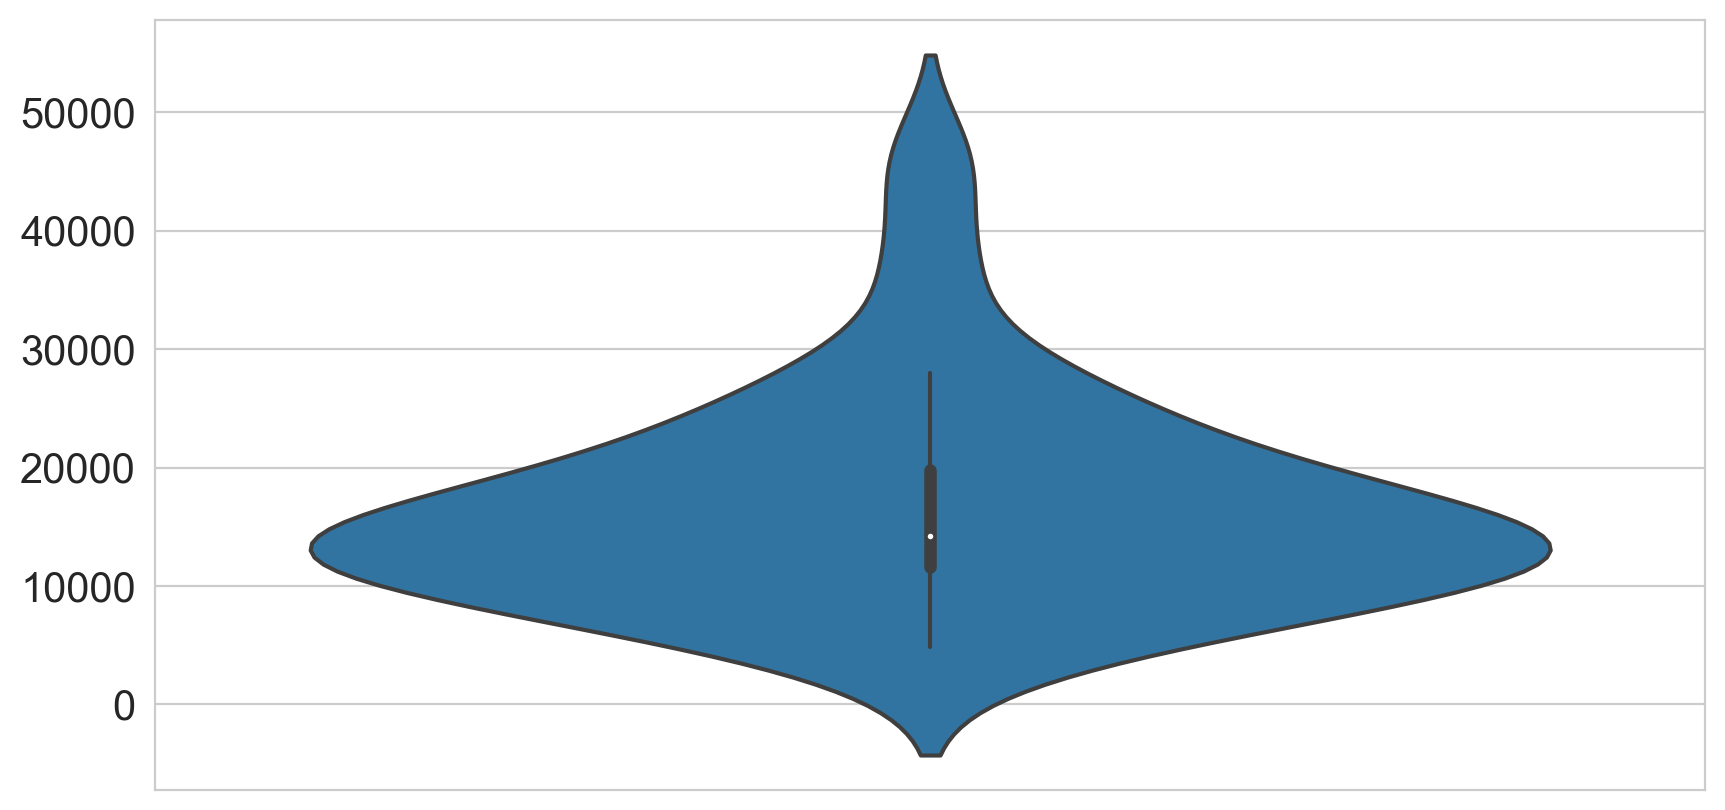

In [16]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(y=user_max, ax=ax)

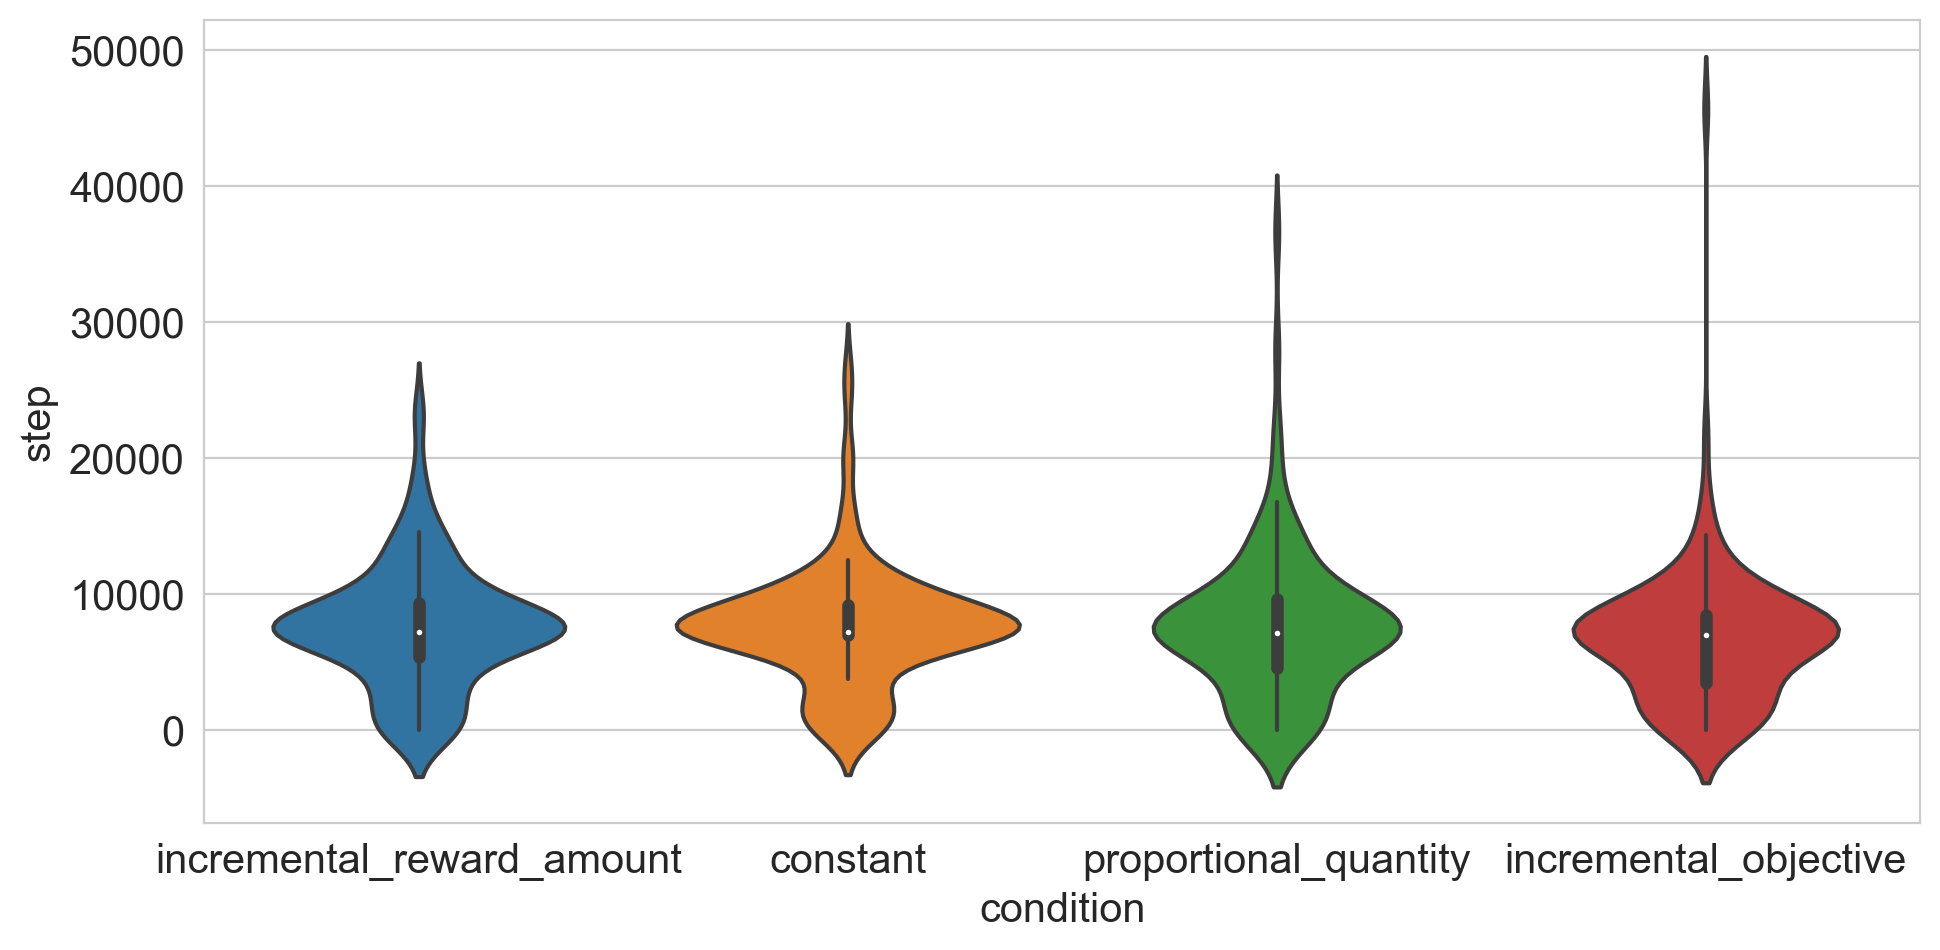

In [17]:
order = df_step.condition.unique()

plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(x="condition", y="step", data=df_step, ax=ax, order=order)
fig.tight_layout()

user 02MY


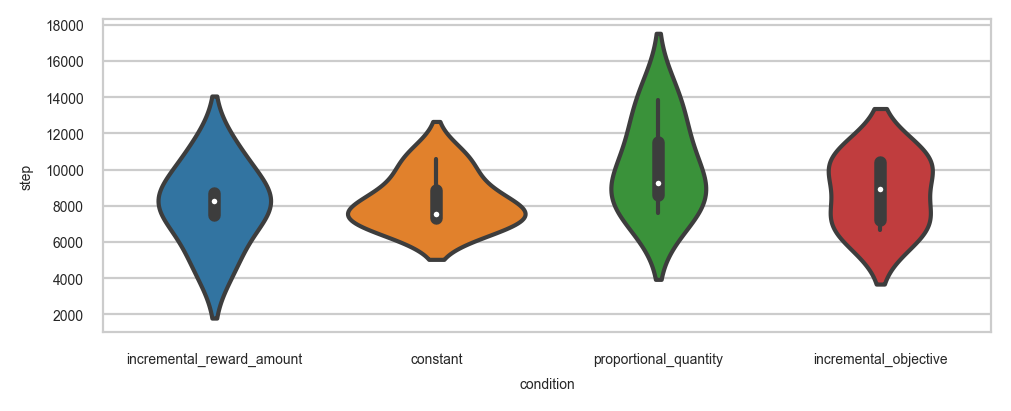

user 102P


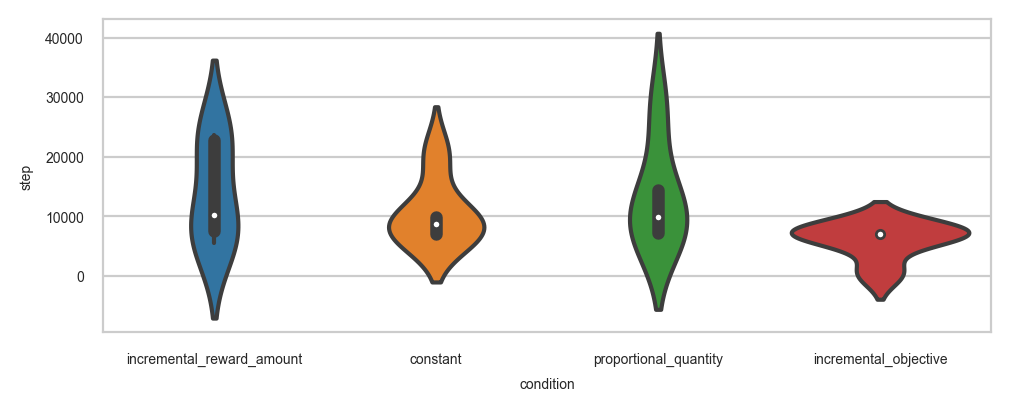

user 11AV


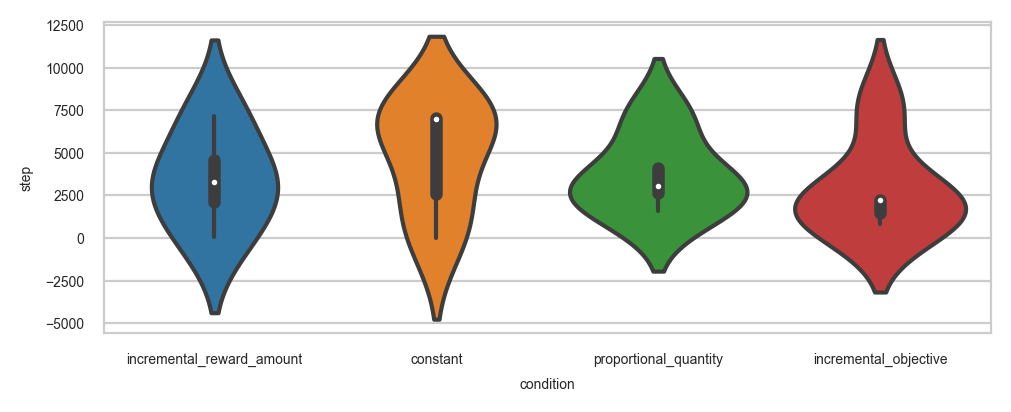

user 11KD


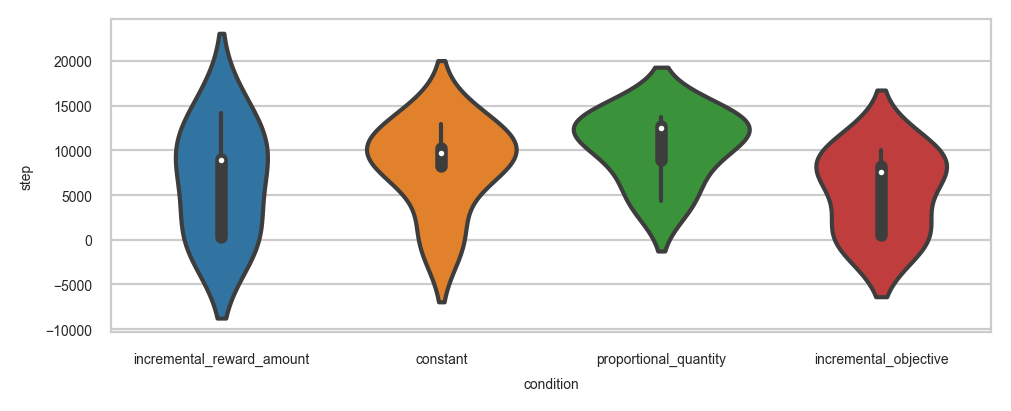

user 12JA


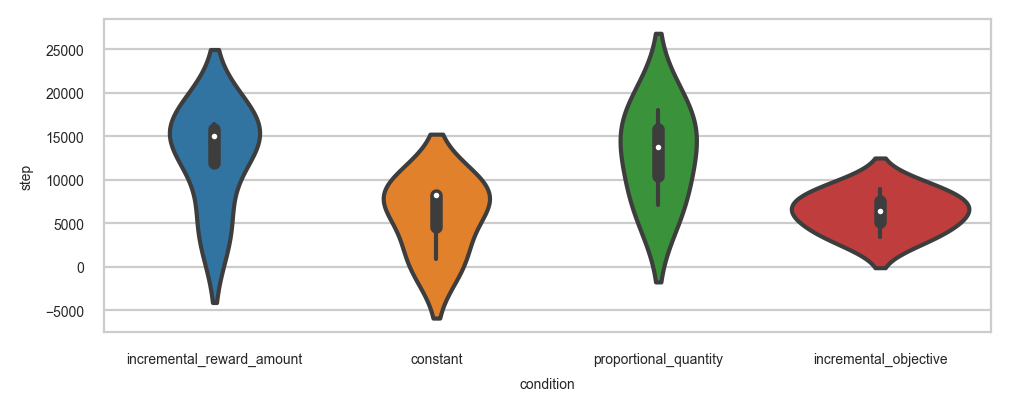

user 18DA


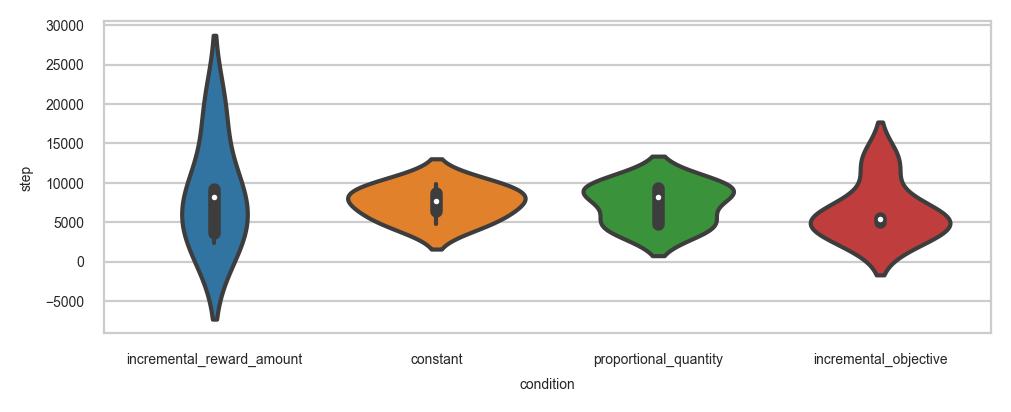

user 19AN


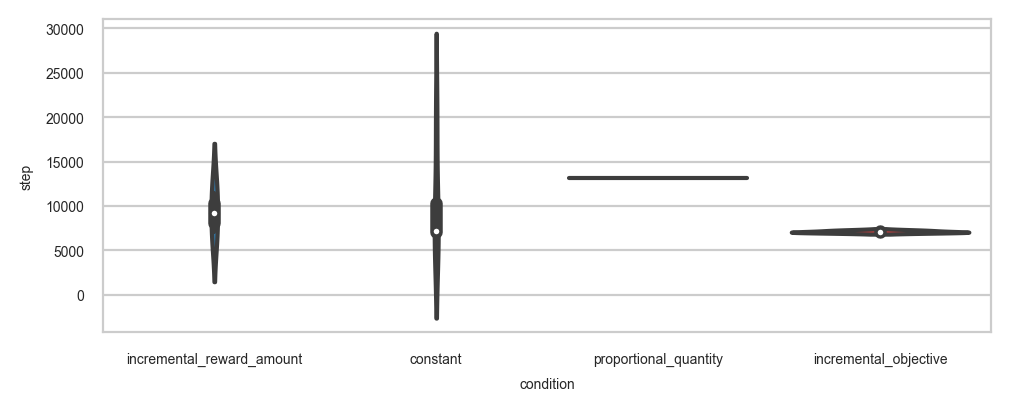

user 19EN


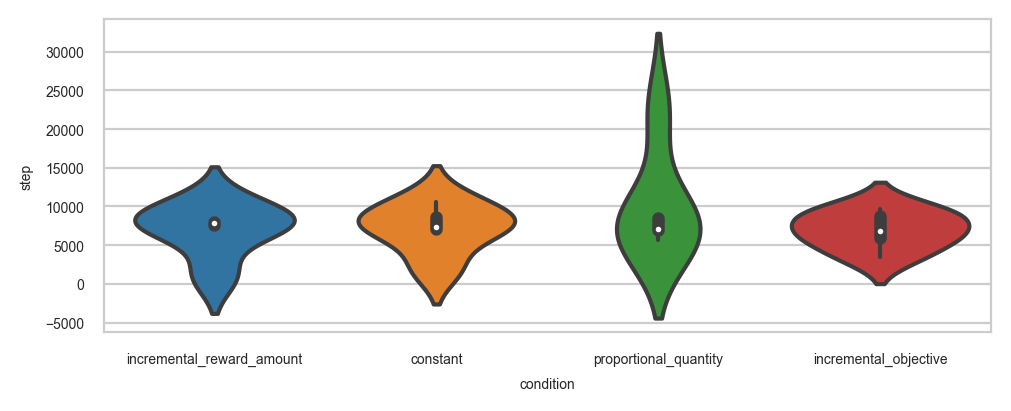

user 272W


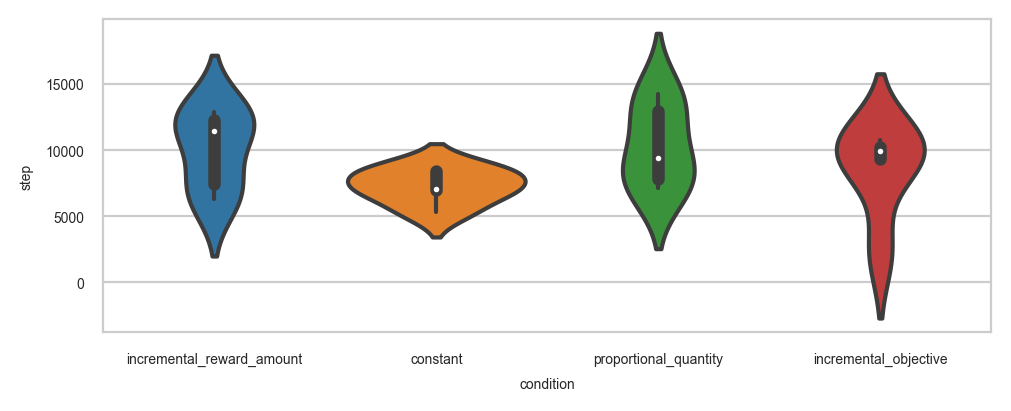

user 302M


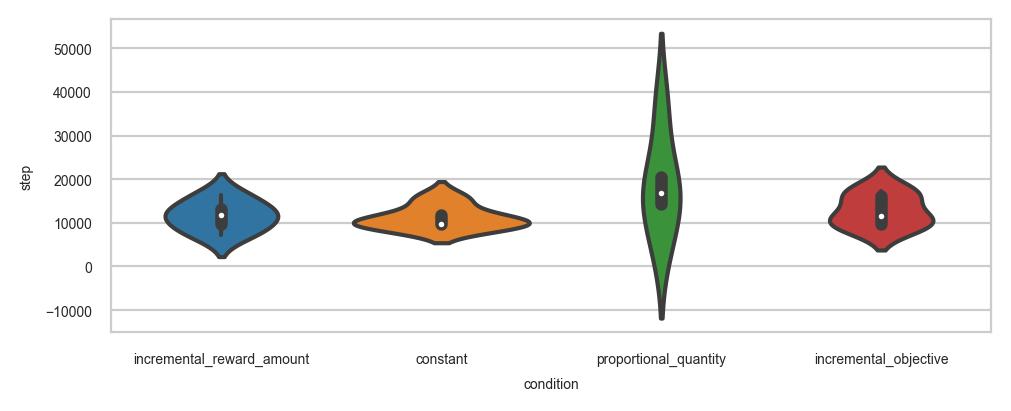

user 13KU


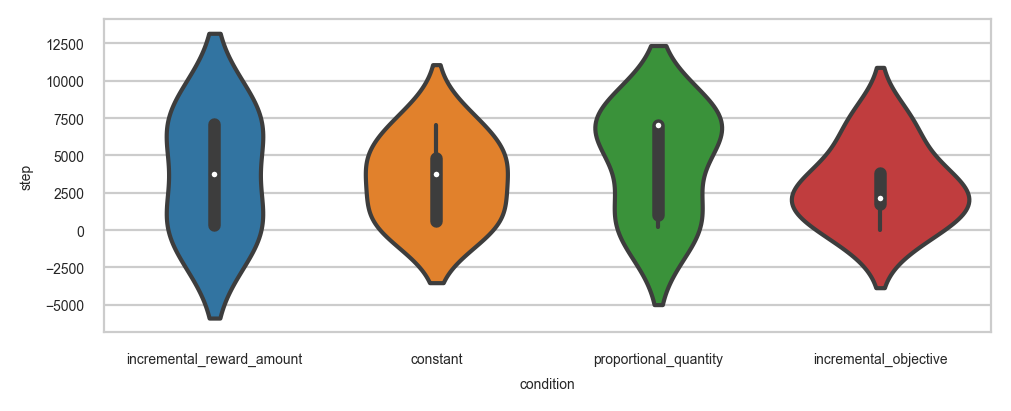

user 152O


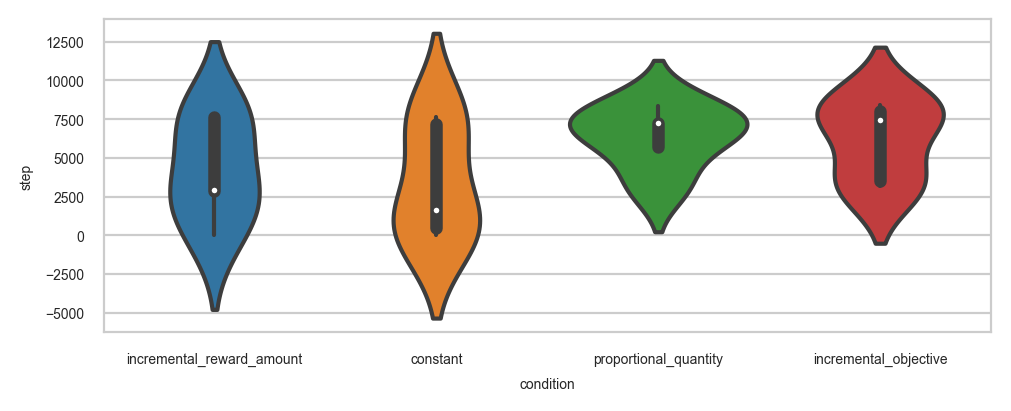

user 15SM


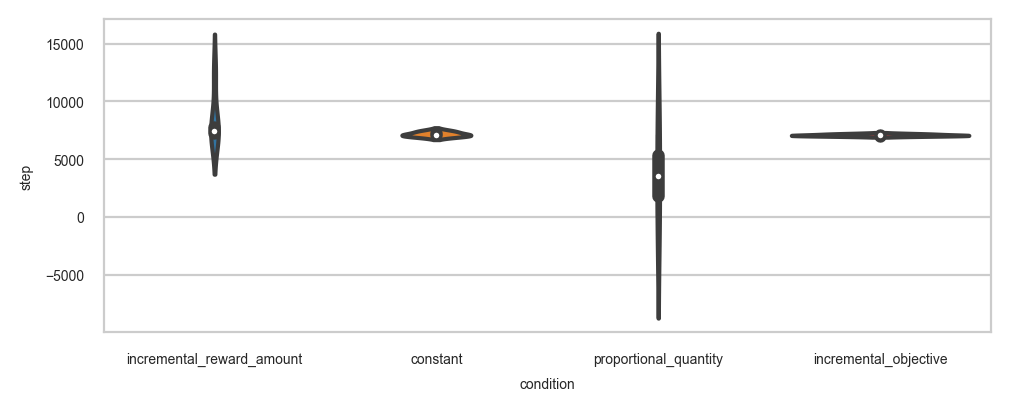

user 252S


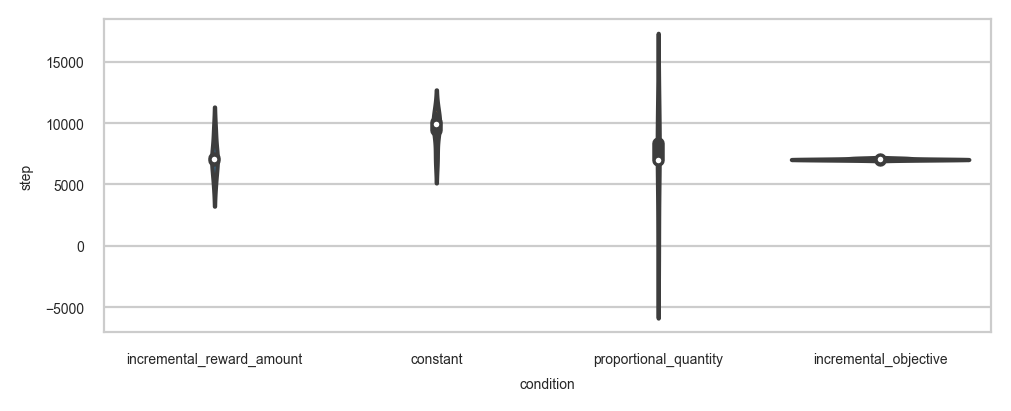

user 27SI


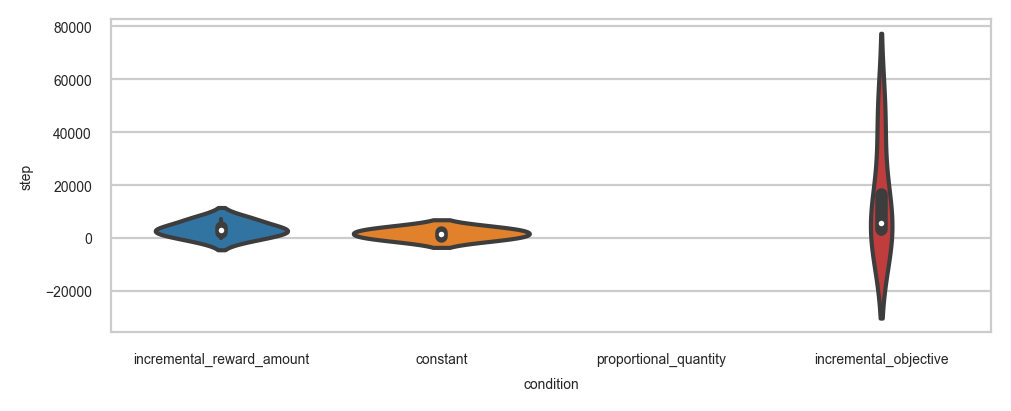

user 28OM


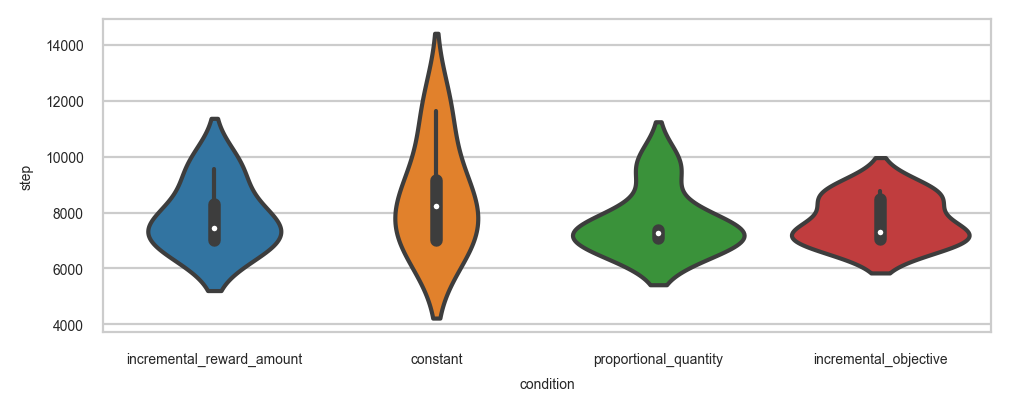

user 1362


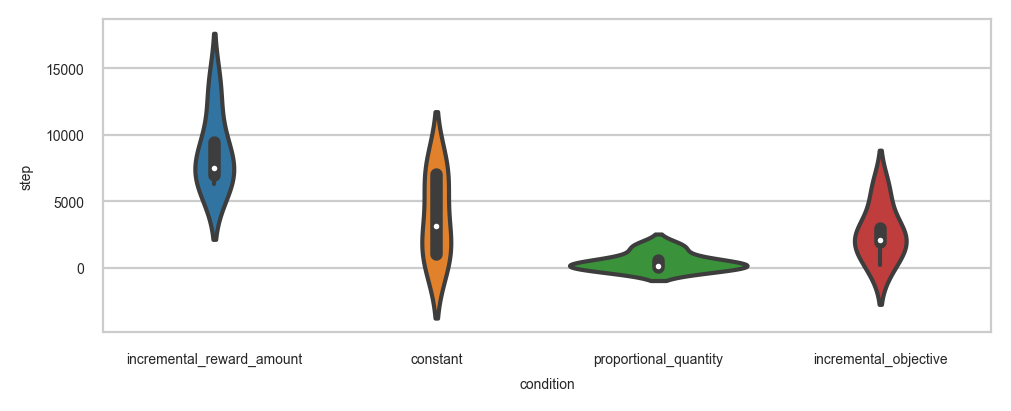

user 09AU


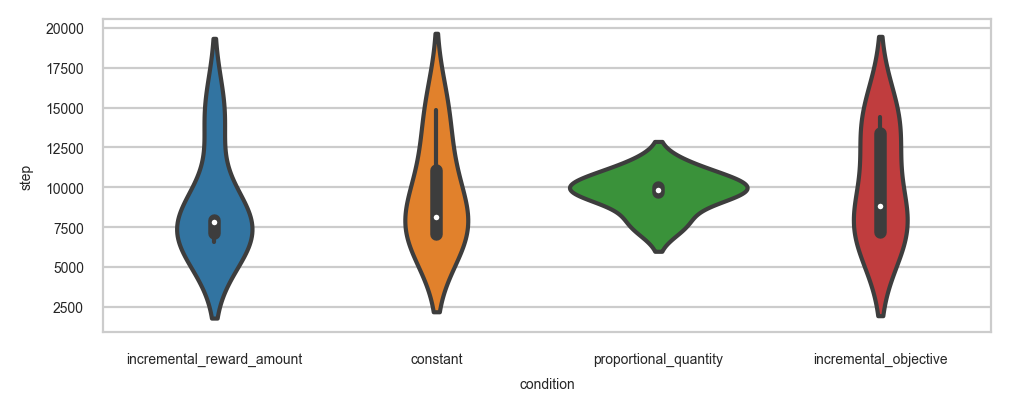

user 11SA


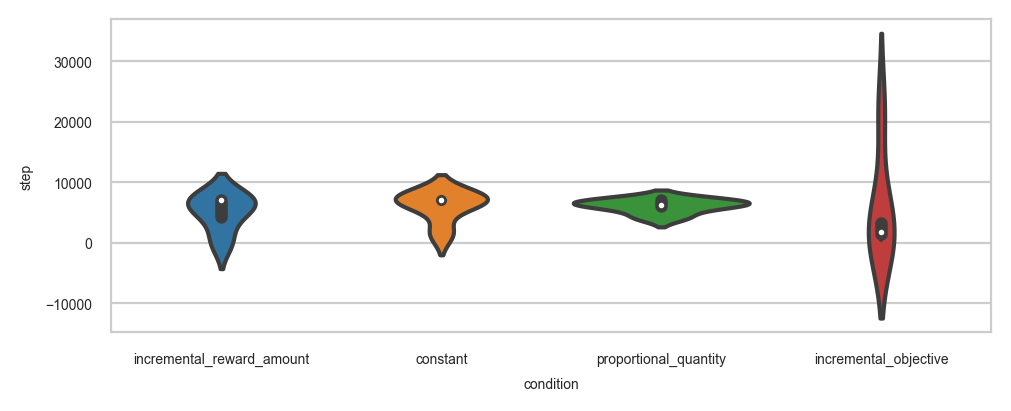

user 132L


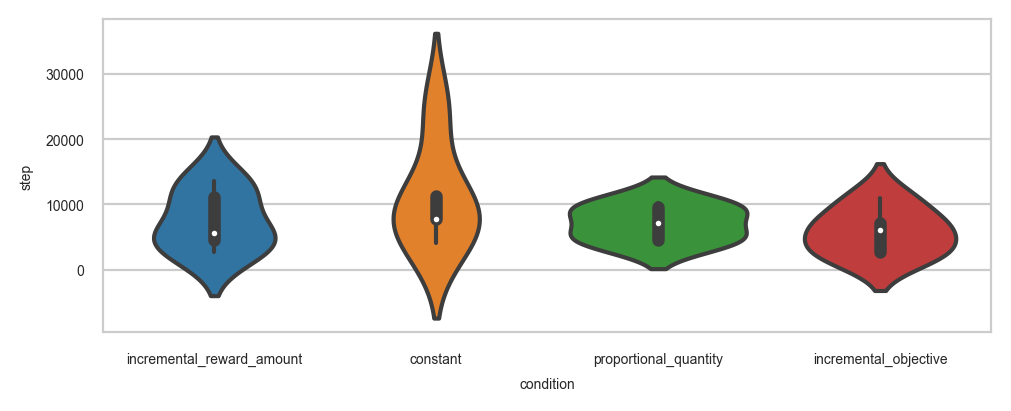

user 152A


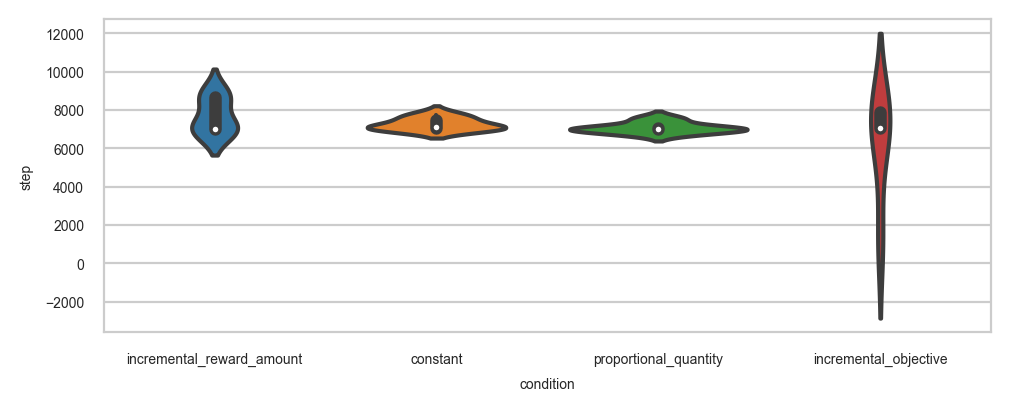

user 162W


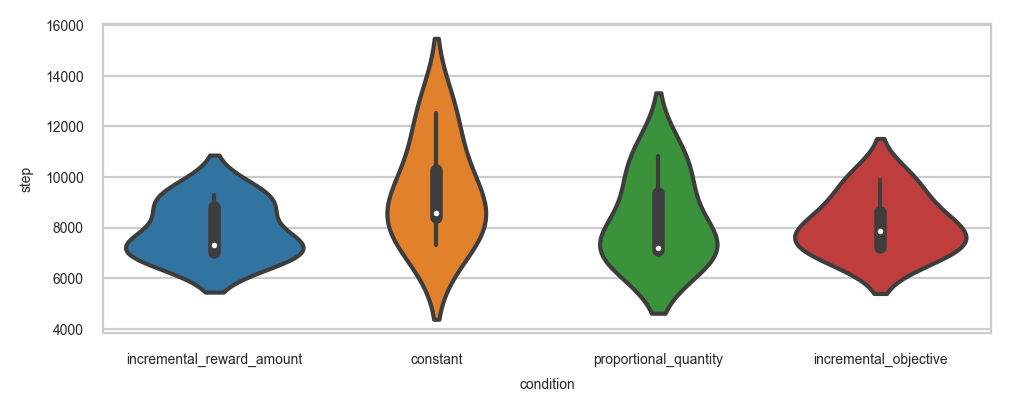

user 192Z


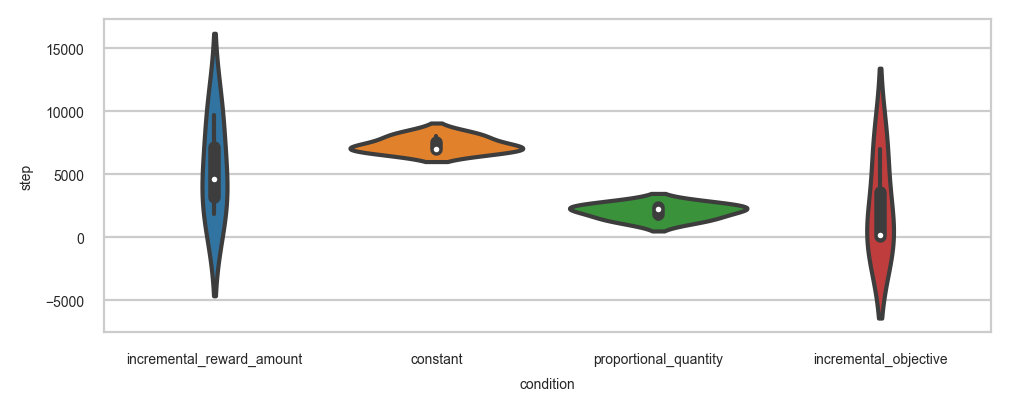

user 24SA


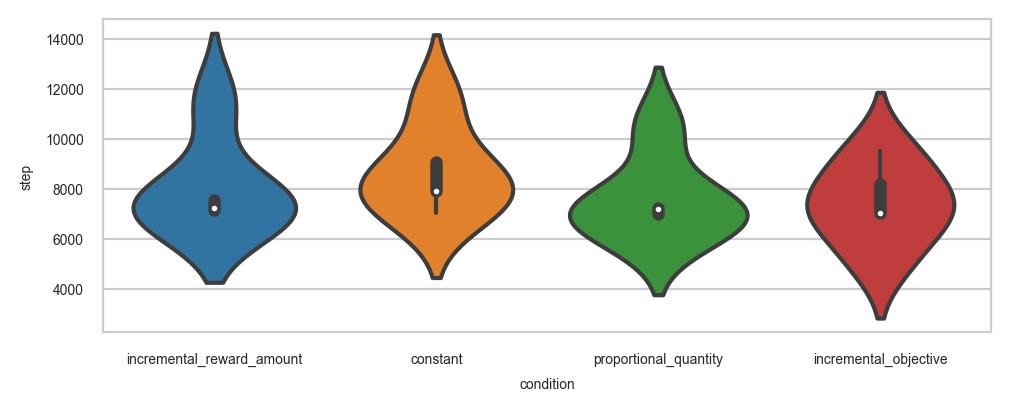

user 25TI


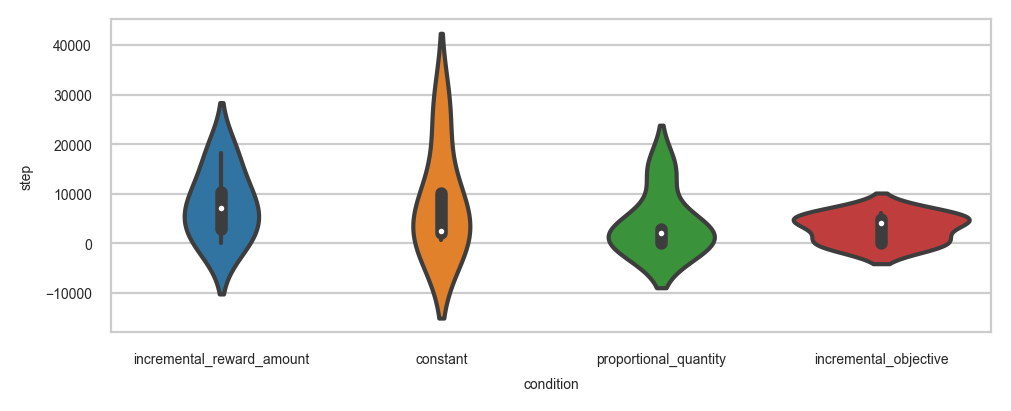

user 272L


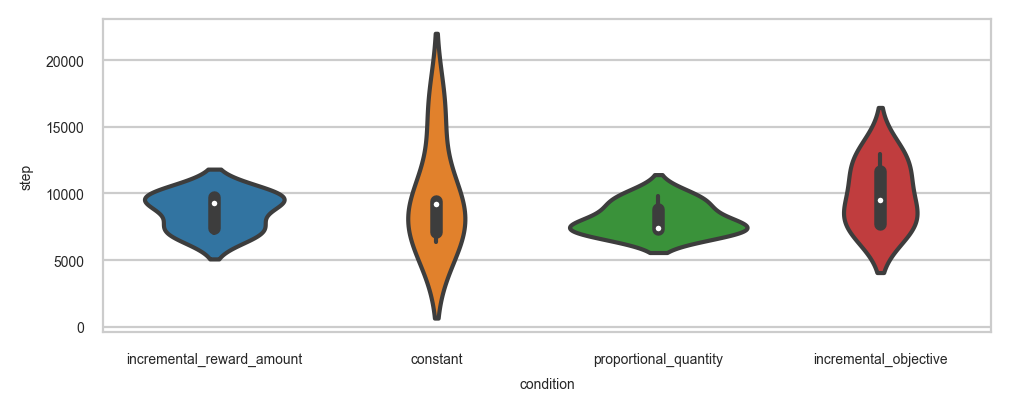

user 15MM


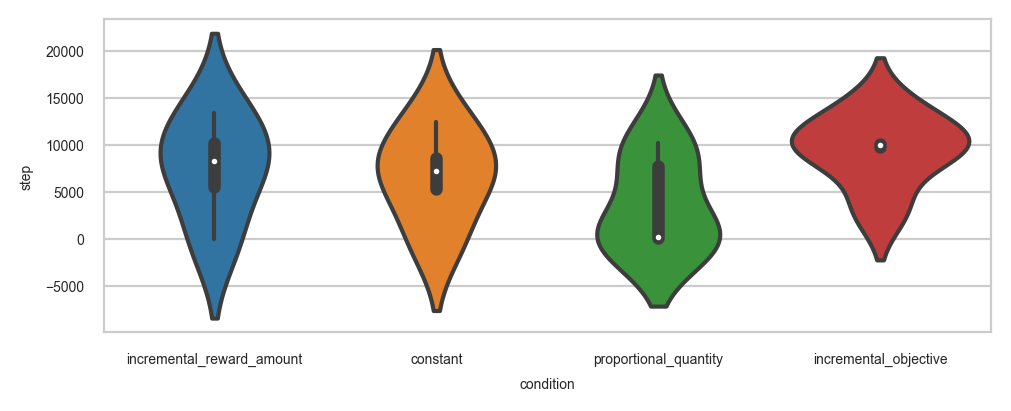

user 09A1


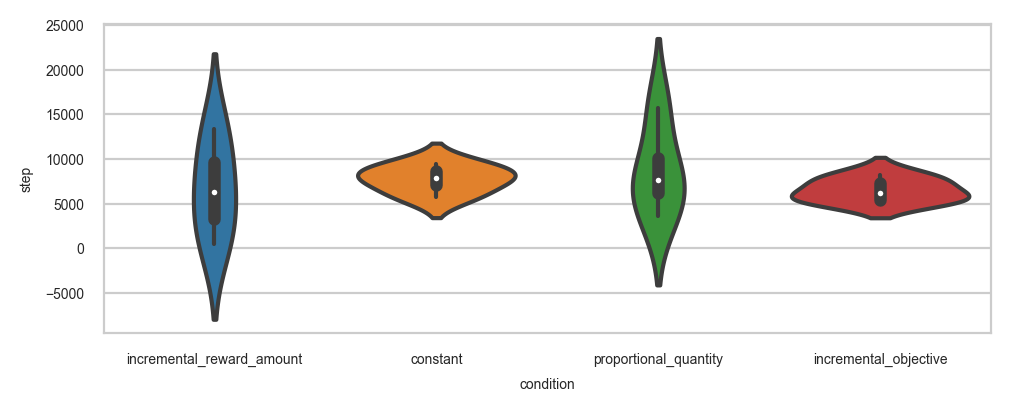

user 06AS


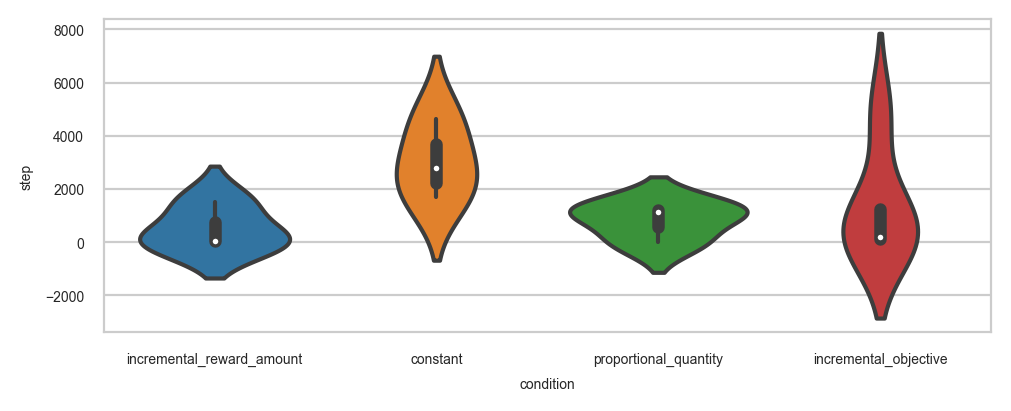

In [14]:
for user in df_step.user.unique():
    print("user", user)

    user_df = df_step[df_step.user == user]
    # print(user_df.groupby("condition").mean("step"))

    plt.rcParams.update({'font.size': 5})
    fig, ax = plt.subplots(figsize=(5, 2))
    sns.violinplot(x="condition", y="step", data=user_df, ax=ax, order=order)
    fig.tight_layout()
    plt.show()